# CS224N Assignment 1: Exploring Word Vectors (25 Points)
### <font color='blue'> Due 4:30pm, Tue Jan 14 </font>

Welcome to CS224n! 

Before you start, make sure you read the README.txt in the same directory as this notebook. You will find many provided codes in the notebook. We highly encourage you to read and understand the provided codes as part of the learning :-)

In [1]:
# All Import Statements Defined Here
# Note: Do not add to this list.
# ----------------

import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
nltk.download('reuters')
from nltk.corpus import reuters
import numpy as np
import pandas as pd
import random
import re
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from collections import *
from nltk.stem import WordNetLemmatizer 
  

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)
# ----------------

[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\nimmi\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!


## Word Vectors

Word Vectors are often used as a fundamental component for downstream NLP tasks, e.g. question answering, text generation, translation, etc., so it is important to build some intuitions as to their strengths and weaknesses. Here, you will explore two types of word vectors: those derived from *co-occurrence matrices*, and those derived via *GloVe*. 

**Assignment Notes:** Please make sure to save the notebook as you go along. Submission Instructions are located at the bottom of the notebook.

**Note on Terminology:** The terms "word vectors" and "word embeddings" are often used interchangeably. The term "embedding" refers to the fact that we are encoding aspects of a word's meaning in a lower dimensional space. As [Wikipedia](https://en.wikipedia.org/wiki/Word_embedding) states, "*conceptually it involves a mathematical embedding from a space with one dimension per word to a continuous vector space with a much lower dimension*".

## Part 1: Count-Based Word Vectors (10 points)

Most word vector models start from the following idea:

*You shall know a word by the company it keeps ([Firth, J. R. 1957:11](https://en.wikipedia.org/wiki/John_Rupert_Firth))*

Many word vector implementations are driven by the idea that similar words, i.e., (near) synonyms, will be used in similar contexts. As a result, similar words will often be spoken or written along with a shared subset of words, i.e., contexts. By examining these contexts, we can try to develop embeddings for our words. With this intuition in mind, many "old school" approaches to constructing word vectors relied on word counts. Here we elaborate upon one of those strategies, *co-occurrence matrices* (for more information, see [here](http://web.stanford.edu/class/cs124/lec/vectorsemantics.video.pdf) or [here](https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285)).

### Co-Occurrence

A co-occurrence matrix counts how often things co-occur in some environment. Given some word $w_i$ occurring in the document, we consider the *context window* surrounding $w_i$. Supposing our fixed window size is $n$, then this is the $n$ preceding and $n$ subsequent words in that document, i.e. words $w_{i-n} \dots w_{i-1}$ and $w_{i+1} \dots w_{i+n}$. We build a *co-occurrence matrix* $M$, which is a symmetric word-by-word matrix in which $M_{ij}$ is the number of times $w_j$ appears inside $w_i$'s window among all documents.

**Example: Co-Occurrence with Fixed Window of n=1**:

Document 1: "all that glitters is not gold"

Document 2: "all is well that ends well"


|     *    | `<START>` | all | that | glitters | is   | not  | gold  | well | ends | `<END>` |
|----------|-------|-----|------|----------|------|------|-------|------|------|-----|
| `<START>`    | 0     | 2   | 0    | 0        | 0    | 0    | 0     | 0    | 0    | 0   |
| all      | 2     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| that     | 0     | 1   | 0    | 1        | 0    | 0    | 0     | 1    | 1    | 0   |
| glitters | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| is       | 0     | 1   | 0    | 1        | 0    | 1    | 0     | 1    | 0    | 0   |
| not      | 0     | 0   | 0    | 0        | 1    | 0    | 1     | 0    | 0    | 0   |
| gold     | 0     | 0   | 0    | 0        | 0    | 1    | 0     | 0    | 0    | 1   |
| well     | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 1    | 1   |
| ends     | 0     | 0   | 1    | 0        | 0    | 0    | 0     | 1    | 0    | 0   |
| `<END>`      | 0     | 0   | 0    | 0        | 0    | 0    | 1     | 1    | 0    | 0   |

**Note:** In NLP, we often add `<START>` and `<END>` tokens to represent the beginning and end of sentences, paragraphs or documents. In thise case we imagine `<START>` and `<END>` tokens encapsulating each document, e.g., "`<START>` All that glitters is not gold `<END>`", and include these tokens in our co-occurrence counts.

The rows (or columns) of this matrix provide one type of word vectors (those based on word-word co-occurrence), but the vectors will be large in general (linear in the number of distinct words in a corpus). Thus, our next step is to run *dimensionality reduction*. In particular, we will run *SVD (Singular Value Decomposition)*, which is a kind of generalized *PCA (Principal Components Analysis)* to select the top $k$ principal components. Here's a visualization of dimensionality reduction with SVD. In this picture our co-occurrence matrix is $A$ with $n$ rows corresponding to $n$ words. We obtain a full matrix decomposition, with the singular values ordered in the diagonal $S$ matrix, and our new, shorter length-$k$ word vectors in $U_k$.

For more information about Dimensionality reduction using SVD = https://www.youtube.com/watch?v=UyAfmAZU_WI

![Picture of an SVD](./imgs/svd.png "SVD")

This reduced-dimensionality co-occurrence representation preserves semantic relationships between words, e.g. *doctor* and *hospital* will be closer than *doctor* and *dog*. 

**Notes:** If you can barely remember what an eigenvalue is, here's [a slow, friendly introduction to SVD](https://davetang.org/file/Singular_Value_Decomposition_Tutorial.pdf). If you want to learn more thoroughly about PCA or SVD, feel free to check out lectures [7](https://web.stanford.edu/class/cs168/l/l7.pdf), [8](http://theory.stanford.edu/~tim/s15/l/l8.pdf), and [9](https://web.stanford.edu/class/cs168/l/l9.pdf) of CS168. These course notes provide a great high-level treatment of these general purpose algorithms. Though, for the purpose of this class, you only need to know how to extract the k-dimensional embeddings by utilizing pre-programmed implementations of these algorithms from the numpy, scipy, or sklearn python packages. In practice, it is challenging to apply full SVD to large corpora because of the memory needed to perform PCA or SVD. However, if you only want the top $k$ vector components for relatively small $k$ — known as [Truncated SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition#Truncated_SVD) — then there are reasonably scalable techniques to compute those iteratively.

### Plotting Co-Occurrence Word Embeddings

Here, we will be using the Reuters (business and financial news) corpus. If you haven't run the import cell at the top of this page, please run it now (click it and press SHIFT-RETURN). The corpus consists of 10,788 news documents totaling 1.3 million words. These documents span 90 categories and are split into train and test. For more details, please see https://www.nltk.org/book/ch02.html. We provide a `read_corpus` function below that pulls out only articles from the "crude" (i.e. news articles about oil, gas, etc.) category. The function also adds `<START>` and `<END>` tokens to each of the documents, and lowercases words. You do **not** have to perform any other kind of pre-processing.

In [31]:
def process_news(news):
    _news = re.sub('^b', "", news)
    _news = re.sub('[\s]+', ' ', _news)
    _news = _news.lower()
    _news = re.sub("[^a-zA-Z]", " ",_news)
     
    return _news
    
def remove_rare_words(corpus, limit):
    counts = Counter()
    for row in corpus:
        counts.update(row)
        
    print("number of words in vocabulary: "+str(len(counts)))
    
    #deleting infrequent words
    print("num_words before:",len(counts.keys()))
    for word in list(counts):
        if counts[word] <= limit :
            del counts[word]
    print("num_words after:",len(counts.keys()))
    _corpus = []
    
    for words in corpus:
        _words = []
        for word in words:
            count = counts[word]
            if count == 0:
                continue
            if word == '':
                continue
            _words.append(word)
        _corpus.append(_words)
        
    return _corpus


def read_corpus():

    data = pd.read_csv("../Datasets/djia/Combined_News_DJIA.csv")
    
    dfs = []
    for i in range(1,25):
        col = "Top"+str(i)
        _df = data[[col, 'Label']]
        _df.columns = ['News', 'Label']
        dfs.append(_df)
    data = pd.concat(dfs,ignore_index=True)
    data = data.dropna()
    data['News'] = data['News'].map(process_news)
    
    Xy_train = data[:int(len(data)*0.8)]
    Xy_test = data[int(len(data)*0.8):]
    
    lemmatizer = WordNetLemmatizer() 

    corpus = [[START_TOKEN] + [lemmatizer.lemmatize(w) for w in c.split(" ")] + [END_TOKEN] for c in Xy_train['News'].values]
    corpus = remove_rare_words(corpus, 5)
    corpus = [item for sublist in corpus for item in sublist]
    return corpus, Xy_train, Xy_test



In [32]:
w = "abilities"
lemmatizer = WordNetLemmatizer() 
lemmatizer.lemmatize(w)

'ability'

In [57]:
corpus, Xy_train, Xy_test = read_corpus()
corpus

number of words in vocabulary: 25848
num_words before: 25848
num_words after: 8005


['<START>',
 'georgia',
 'down',
 'two',
 'russian',
 'warplane',
 'a',
 'country',
 'move',
 'to',
 'brink',
 'of',
 'war',
 '<END>',
 '<START>',
 'why',
 'wont',
 'america',
 'and',
 'nato',
 'help',
 'u',
 'if',
 'they',
 'wont',
 'help',
 'u',
 'now',
 'why',
 'did',
 'we',
 'help',
 'them',
 'in',
 'iraq',
 '<END>',
 '<START>',
 'remember',
 'that',
 'year',
 'old',
 'who',
 'at',
 'the',
 'opening',
 'ceremony',
 'that',
 'wa',
 'fake',
 'too',
 '<END>',
 '<START>',
 'u',
 's',
 'refuse',
 'israel',
 'weapon',
 'to',
 'attack',
 'iran',
 'report',
 '<END>',
 '<START>',
 'all',
 'the',
 'expert',
 'admit',
 'that',
 'we',
 'should',
 'legalise',
 'drug',
 '<END>',
 '<START>',
 'mom',
 'of',
 'missing',
 'gay',
 'man',
 'too',
 'bad',
 'he',
 's',
 'not',
 'a',
 'year',
 'old',
 'then',
 'they',
 'd',
 'still',
 'be',
 'looking',
 'for',
 'him',
 '<END>',
 '<START>',
 'in',
 'an',
 'afghan',
 'prison',
 'the',
 'majority',
 'of',
 'female',
 'prisoner',
 'are',
 'serving',
 'year',

### Question 1.1: Implement `distinct_words` [code] (2 points)

Write a method to work out the distinct words (word types) that occur in the corpus. You can do this with `for` loops, but it's more efficient to do it with Python list comprehensions. In particular, [this](https://coderwall.com/p/rcmaea/flatten-a-list-of-lists-in-one-line-in-python) may be useful to flatten a list of lists. If you're not familiar with Python list comprehensions in general, here's [more information](https://python-3-patterns-idioms-test.readthedocs.io/en/latest/Comprehensions.html).

You may find it useful to use [Python sets](https://www.w3schools.com/python/python_sets.asp) to remove duplicate words.

In [1]:
def distinct_words(corpus):
    print(corpus)
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): list of distinct words across the corpus, sorted (using python 'sorted' function)
            num_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    num_corpus_words = -1
    
    # ------------------
    # Write your implementation here.
    
    flattened_list = [li for li in corpus]
    print(flattened_list)
    corpus_words = sorted(list(set(flattened_list)))
    num_corpus_words = len(corpus_words)


    # ------------------

    return corpus_words, num_corpus_words

In [61]:
distinct_words(corpus)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(['<END>',
  '<START>',
  'a',
  'aaa',
  'abandon',
  'abandoned',
  'abandoning',
  'abbas',
  'abbott',
  'abc',
  'abdel',
  'abdeslam',
  'abducted',
  'abducting',
  'abduction',
  'abdullah',
  'abe',
  'ability',
  'abkhazia',
  'ablaze',
  'able',
  'abnormality',
  'aboard',
  'abolish',
  'abolished',
  'abolishes',
  'aboriginal',
  'abortion',
  'about',
  'above',
  'abroad',
  'abruptly',
  'absence',
  'absolute',
  'absolutely',
  'absurd',
  'abu',
  'abuse',
  'abused',
  'abuser',
  'abusing',
  'abusive',
  'ac',
  'academic',
  'academy',
  'acapulco',
  'accelerated',
  'accelerating',
  'accept',
  'acceptable',
  'acceptance',
  'accepted',
  'accepting',
  'accepts',
  'access',
  'accessing',
  'accessory',
  'accident',
  'accidentally',
  'accompanied',
  'accord',
  'according',
  'account',
  'accountability',
  'accountable',
  'accounting',
  'accuracy',
  'accusation',
  'accuse',
  'accused',
  'accuses',
  'accusing',
  'achieve',
  'achieved',
  'ac

In [62]:
distinct_words(corpus)[1]

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8004

### Question 1.2: Implement `compute_co_occurrence_matrix` [code] (3 points)

Write a method that constructs a co-occurrence matrix for a certain window-size $n$ (with a default of 4), considering words $n$ before and $n$ after the word in the center of the window. Here, we start to use `numpy (np)` to represent vectors, matrices, and tensors. If you're not familiar with NumPy, there's a NumPy tutorial in the second half of this cs231n [Python NumPy tutorial](http://cs231n.github.io/python-numpy-tutorial/).


In [67]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              
              For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
              "All" will co-occur with "<START>", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2Ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, num_words = distinct_words(corpus)
    M = np.zeros((num_words, num_words))
    flattened_corpus = [li for li in corpus]
    word2Ind = {}
    x=0
    
    # ------------------
    # Write your implementation here.
    
    print("flattened_corpus")
    print(len(flattened_corpus))
    for f in range(len(flattened_corpus)):
        j = words.index(flattened_corpus[f])
        word2Ind[flattened_corpus[f]] = j
        for k in range(window_size):
            k = k+1
            for i in range(len(words)):
                count = 0
                
                if (words[i] in [START_TOKEN, END_TOKEN]) and words[j] in [START_TOKEN, END_TOKEN]:
                    continue
                
                if (f-k >=0):
                    if flattened_corpus[f-k]== words[i]:
                        count = count + 1
                if (f+k <len(flattened_corpus)):
                    if flattened_corpus[f+k]== words[i]:
                        count = count + 1

                M[i][j] = M[i][j] + count
        x=x+1
        if x%50==0:
            print(str(x)+"/"+str(len(flattened_corpus)))
        
    
        
    # ------------------
    return M, word2Ind

### Question 1.3: Implement `reduce_to_k_dim` [code] (1 point)

Construct a method that performs dimensionality reduction on the matrix to produce k-dimensional embeddings. Use SVD to take the top k components and produce a new matrix of k-dimensional embeddings. 

**Note:** All of numpy, scipy, and scikit-learn (`sklearn`) provide *some* implementation of SVD, but only scipy and sklearn provide an implementation of Truncated SVD, and only sklearn provides an efficient randomized algorithm for calculating large-scale Truncated SVD. So please use [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

In [68]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    # ------------------
    # Write your implementation here.
        
    svd = TruncatedSVD(n_components=k, n_iter=n_iters)
    M_reduced = svd.fit_transform(M)
    
    # ------------------

    print("Done.")
    return M_reduced

### Question 1.4: Implement `plot_embeddings` [code] (1 point)

Here you will write a function to plot a set of 2D vectors in 2D space. For graphs, we will use Matplotlib (`plt`).

For this example, you may find it useful to adapt [this code](https://www.pythonmembers.club/2018/05/08/matplotlib-scatter-plot-annotate-set-text-at-label-each-point/). In the future, a good way to make a plot is to look at [the Matplotlib gallery](https://matplotlib.org/gallery/index.html), find a plot that looks somewhat like what you want, and adapt the code they give.

In [69]:
def plot_embeddings(M_reduced, word2Ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2Ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
            word2Ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    # ------------------
    # Write your implementation here.

    """for i,word in enumerate(word2Ind):
        x = M_reduced[i][0]
        y = M_reduced[i][1]
        plt.scatter(x, y, marker='x', color='red')
        plt.text(x, y, word, fontsize=9)"""
       
    for word in words:
        i = word2Ind[word]
        x = M_reduced[i][0]
        y = M_reduced[i][1]
        plt.scatter(x, y, marker='x', color='red')
        plt.text(x, y, word, fontsize=9)

    plt.show()

    # ------------------

### Question 1.5: Co-Occurrence Plot Analysis [written] (3 points)

Now we will put together all the parts you have written! We will compute the co-occurrence matrix with fixed window of 4 (the default window size), over the Reuters "crude" (oil) corpus. Then we will use TruncatedSVD to compute 2-dimensional embeddings of each word. TruncatedSVD returns U\*S, so we need to normalize the returned vectors, so that all the vectors will appear around the unit circle (therefore closeness is directional closeness). **Note**: The line of code below that does the normalizing uses the NumPy concept of *broadcasting*. If you don't know about broadcasting, check out
[Computation on Arrays: Broadcasting by Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html).

Run the below cell to produce the plot. It'll probably take a few seconds to run. What clusters together in 2-dimensional embedding space? What doesn't cluster together that you might think should have?  **Note:** "bpd" stands for "barrels per day" and is a commonly used abbreviation in crude oil topic articles.

In [70]:
# ----------------------------------
# Run This Cell to Produce Your Plot
# ----------------------------------
corpus, Xy_train, Xy_test  = read_corpus()
print("reuters_corpus = read_corpus() done")
print(len(corpus))
M_co_occurrence, word2Ind_co_occurrence = compute_co_occurrence_matrix(corpus)
print("M_co_occurrence, word2Ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus) done")

number of words in vocabulary: 25848
num_words before: 25848
num_words after: 8005


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



flattened_corpus
732253
50/732253
100/732253
150/732253
200/732253
250/732253
300/732253
350/732253
400/732253
450/732253
500/732253
550/732253
600/732253
650/732253
700/732253
750/732253
800/732253
850/732253
900/732253
950/732253
1000/732253
1050/732253
1100/732253
1150/732253
1200/732253
1250/732253
1300/732253
1350/732253
1400/732253
1450/732253
1500/732253
1550/732253
1600/732253
1650/732253
1700/732253
1750/732253
1800/732253
1850/732253
1900/732253
1950/732253
2000/732253
2050/732253
2100/732253
2150/732253
2200/732253
2250/732253
2300/732253
2350/732253
2400/732253
2450/732253
2500/732253
2550/732253
2600/732253
2650/732253
2700/732253
2750/732253
2800/732253
2850/732253
2900/732253
2950/732253
3000/732253
3050/732253
3100/732253
3150/732253
3200/732253
3250/732253
3300/732253
3350/732253
3400/732253
3450/732253
3500/732253
3550/732253
3600/732253
3650/732253
3700/732253
3750/732253
3800/732253
3850/732253
3900/732253
3950/732253
4000/732253
4050/732253
4100/732253
4150/732253


32350/732253
32400/732253
32450/732253
32500/732253
32550/732253
32600/732253
32650/732253
32700/732253
32750/732253
32800/732253
32850/732253
32900/732253
32950/732253
33000/732253
33050/732253
33100/732253
33150/732253
33200/732253
33250/732253
33300/732253
33350/732253
33400/732253
33450/732253
33500/732253
33550/732253
33600/732253
33650/732253
33700/732253
33750/732253
33800/732253
33850/732253
33900/732253
33950/732253
34000/732253
34050/732253
34100/732253
34150/732253
34200/732253
34250/732253
34300/732253
34350/732253
34400/732253
34450/732253
34500/732253
34550/732253
34600/732253
34650/732253
34700/732253
34750/732253
34800/732253
34850/732253
34900/732253
34950/732253
35000/732253
35050/732253
35100/732253
35150/732253
35200/732253
35250/732253
35300/732253
35350/732253
35400/732253
35450/732253
35500/732253
35550/732253
35600/732253
35650/732253
35700/732253
35750/732253
35800/732253
35850/732253
35900/732253
35950/732253
36000/732253
36050/732253
36100/732253
36150/732253

63900/732253
63950/732253
64000/732253
64050/732253
64100/732253
64150/732253
64200/732253
64250/732253
64300/732253
64350/732253
64400/732253
64450/732253
64500/732253
64550/732253
64600/732253
64650/732253
64700/732253
64750/732253
64800/732253
64850/732253
64900/732253
64950/732253
65000/732253
65050/732253
65100/732253
65150/732253
65200/732253
65250/732253
65300/732253
65350/732253
65400/732253
65450/732253
65500/732253
65550/732253
65600/732253
65650/732253
65700/732253
65750/732253
65800/732253
65850/732253
65900/732253
65950/732253
66000/732253
66050/732253
66100/732253
66150/732253
66200/732253
66250/732253
66300/732253
66350/732253
66400/732253
66450/732253
66500/732253
66550/732253
66600/732253
66650/732253
66700/732253
66750/732253
66800/732253
66850/732253
66900/732253
66950/732253
67000/732253
67050/732253
67100/732253
67150/732253
67200/732253
67250/732253
67300/732253
67350/732253
67400/732253
67450/732253
67500/732253
67550/732253
67600/732253
67650/732253
67700/732253

95450/732253
95500/732253
95550/732253
95600/732253
95650/732253
95700/732253
95750/732253
95800/732253
95850/732253
95900/732253
95950/732253
96000/732253
96050/732253
96100/732253
96150/732253
96200/732253
96250/732253
96300/732253
96350/732253
96400/732253
96450/732253
96500/732253
96550/732253
96600/732253
96650/732253
96700/732253
96750/732253
96800/732253
96850/732253
96900/732253
96950/732253
97000/732253
97050/732253
97100/732253
97150/732253
97200/732253
97250/732253
97300/732253
97350/732253
97400/732253
97450/732253
97500/732253
97550/732253
97600/732253
97650/732253
97700/732253
97750/732253
97800/732253
97850/732253
97900/732253
97950/732253
98000/732253
98050/732253
98100/732253
98150/732253
98200/732253
98250/732253
98300/732253
98350/732253
98400/732253
98450/732253
98500/732253
98550/732253
98600/732253
98650/732253
98700/732253
98750/732253
98800/732253
98850/732253
98900/732253
98950/732253
99000/732253
99050/732253
99100/732253
99150/732253
99200/732253
99250/732253

125050/732253
125100/732253
125150/732253
125200/732253
125250/732253
125300/732253
125350/732253
125400/732253
125450/732253
125500/732253
125550/732253
125600/732253
125650/732253
125700/732253
125750/732253
125800/732253
125850/732253
125900/732253
125950/732253
126000/732253
126050/732253
126100/732253
126150/732253
126200/732253
126250/732253
126300/732253
126350/732253
126400/732253
126450/732253
126500/732253
126550/732253
126600/732253
126650/732253
126700/732253
126750/732253
126800/732253
126850/732253
126900/732253
126950/732253
127000/732253
127050/732253
127100/732253
127150/732253
127200/732253
127250/732253
127300/732253
127350/732253
127400/732253
127450/732253
127500/732253
127550/732253
127600/732253
127650/732253
127700/732253
127750/732253
127800/732253
127850/732253
127900/732253
127950/732253
128000/732253
128050/732253
128100/732253
128150/732253
128200/732253
128250/732253
128300/732253
128350/732253
128400/732253
128450/732253
128500/732253
128550/732253
128600

154350/732253
154400/732253
154450/732253
154500/732253
154550/732253
154600/732253
154650/732253
154700/732253
154750/732253
154800/732253
154850/732253
154900/732253
154950/732253
155000/732253
155050/732253
155100/732253
155150/732253
155200/732253
155250/732253
155300/732253
155350/732253
155400/732253
155450/732253
155500/732253
155550/732253
155600/732253
155650/732253
155700/732253
155750/732253
155800/732253
155850/732253
155900/732253
155950/732253
156000/732253
156050/732253
156100/732253
156150/732253
156200/732253
156250/732253
156300/732253
156350/732253
156400/732253
156450/732253
156500/732253
156550/732253
156600/732253
156650/732253
156700/732253
156750/732253
156800/732253
156850/732253
156900/732253
156950/732253
157000/732253
157050/732253
157100/732253
157150/732253
157200/732253
157250/732253
157300/732253
157350/732253
157400/732253
157450/732253
157500/732253
157550/732253
157600/732253
157650/732253
157700/732253
157750/732253
157800/732253
157850/732253
157900

183650/732253
183700/732253
183750/732253
183800/732253
183850/732253
183900/732253
183950/732253
184000/732253
184050/732253
184100/732253
184150/732253
184200/732253
184250/732253
184300/732253
184350/732253
184400/732253
184450/732253
184500/732253
184550/732253
184600/732253
184650/732253
184700/732253
184750/732253
184800/732253
184850/732253
184900/732253
184950/732253
185000/732253
185050/732253
185100/732253
185150/732253
185200/732253
185250/732253
185300/732253
185350/732253
185400/732253
185450/732253
185500/732253
185550/732253
185600/732253
185650/732253
185700/732253
185750/732253
185800/732253
185850/732253
185900/732253
185950/732253
186000/732253
186050/732253
186100/732253
186150/732253
186200/732253
186250/732253
186300/732253
186350/732253
186400/732253
186450/732253
186500/732253
186550/732253
186600/732253
186650/732253
186700/732253
186750/732253
186800/732253
186850/732253
186900/732253
186950/732253
187000/732253
187050/732253
187100/732253
187150/732253
187200

212950/732253
213000/732253
213050/732253
213100/732253
213150/732253
213200/732253
213250/732253
213300/732253
213350/732253
213400/732253
213450/732253
213500/732253
213550/732253
213600/732253
213650/732253
213700/732253
213750/732253
213800/732253
213850/732253
213900/732253
213950/732253
214000/732253
214050/732253
214100/732253
214150/732253
214200/732253
214250/732253
214300/732253
214350/732253
214400/732253
214450/732253
214500/732253
214550/732253
214600/732253
214650/732253
214700/732253
214750/732253
214800/732253
214850/732253
214900/732253
214950/732253
215000/732253
215050/732253
215100/732253
215150/732253
215200/732253
215250/732253
215300/732253
215350/732253
215400/732253
215450/732253
215500/732253
215550/732253
215600/732253
215650/732253
215700/732253
215750/732253
215800/732253
215850/732253
215900/732253
215950/732253
216000/732253
216050/732253
216100/732253
216150/732253
216200/732253
216250/732253
216300/732253
216350/732253
216400/732253
216450/732253
216500

242250/732253
242300/732253
242350/732253
242400/732253
242450/732253
242500/732253
242550/732253
242600/732253
242650/732253
242700/732253
242750/732253
242800/732253
242850/732253
242900/732253
242950/732253
243000/732253
243050/732253
243100/732253
243150/732253
243200/732253
243250/732253
243300/732253
243350/732253
243400/732253
243450/732253
243500/732253
243550/732253
243600/732253
243650/732253
243700/732253
243750/732253
243800/732253
243850/732253
243900/732253
243950/732253
244000/732253
244050/732253
244100/732253
244150/732253
244200/732253
244250/732253
244300/732253
244350/732253
244400/732253
244450/732253
244500/732253
244550/732253
244600/732253
244650/732253
244700/732253
244750/732253
244800/732253
244850/732253
244900/732253
244950/732253
245000/732253
245050/732253
245100/732253
245150/732253
245200/732253
245250/732253
245300/732253
245350/732253
245400/732253
245450/732253
245500/732253
245550/732253
245600/732253
245650/732253
245700/732253
245750/732253
245800

271550/732253
271600/732253
271650/732253
271700/732253
271750/732253
271800/732253
271850/732253
271900/732253
271950/732253
272000/732253
272050/732253
272100/732253
272150/732253
272200/732253
272250/732253
272300/732253
272350/732253
272400/732253
272450/732253
272500/732253
272550/732253
272600/732253
272650/732253
272700/732253
272750/732253
272800/732253
272850/732253
272900/732253
272950/732253
273000/732253
273050/732253
273100/732253
273150/732253
273200/732253
273250/732253
273300/732253
273350/732253
273400/732253
273450/732253
273500/732253
273550/732253
273600/732253
273650/732253
273700/732253
273750/732253
273800/732253
273850/732253
273900/732253
273950/732253
274000/732253
274050/732253
274100/732253
274150/732253
274200/732253
274250/732253
274300/732253
274350/732253
274400/732253
274450/732253
274500/732253
274550/732253
274600/732253
274650/732253
274700/732253
274750/732253
274800/732253
274850/732253
274900/732253
274950/732253
275000/732253
275050/732253
275100

300850/732253
300900/732253
300950/732253
301000/732253
301050/732253
301100/732253
301150/732253
301200/732253
301250/732253
301300/732253
301350/732253
301400/732253
301450/732253
301500/732253
301550/732253
301600/732253
301650/732253
301700/732253
301750/732253
301800/732253
301850/732253
301900/732253
301950/732253
302000/732253
302050/732253
302100/732253
302150/732253
302200/732253
302250/732253
302300/732253
302350/732253
302400/732253
302450/732253
302500/732253
302550/732253
302600/732253
302650/732253
302700/732253
302750/732253
302800/732253
302850/732253
302900/732253
302950/732253
303000/732253
303050/732253
303100/732253
303150/732253
303200/732253
303250/732253
303300/732253
303350/732253
303400/732253
303450/732253
303500/732253
303550/732253
303600/732253
303650/732253
303700/732253
303750/732253
303800/732253
303850/732253
303900/732253
303950/732253
304000/732253
304050/732253
304100/732253
304150/732253
304200/732253
304250/732253
304300/732253
304350/732253
304400

330150/732253
330200/732253
330250/732253
330300/732253
330350/732253
330400/732253
330450/732253
330500/732253
330550/732253
330600/732253
330650/732253
330700/732253
330750/732253
330800/732253
330850/732253
330900/732253
330950/732253
331000/732253
331050/732253
331100/732253
331150/732253
331200/732253
331250/732253
331300/732253
331350/732253
331400/732253
331450/732253
331500/732253
331550/732253
331600/732253
331650/732253
331700/732253
331750/732253
331800/732253
331850/732253
331900/732253
331950/732253
332000/732253
332050/732253
332100/732253
332150/732253
332200/732253
332250/732253
332300/732253
332350/732253
332400/732253
332450/732253
332500/732253
332550/732253
332600/732253
332650/732253
332700/732253
332750/732253
332800/732253
332850/732253
332900/732253
332950/732253
333000/732253
333050/732253
333100/732253
333150/732253
333200/732253
333250/732253
333300/732253
333350/732253
333400/732253
333450/732253
333500/732253
333550/732253
333600/732253
333650/732253
333700

359450/732253
359500/732253
359550/732253
359600/732253
359650/732253
359700/732253
359750/732253
359800/732253
359850/732253
359900/732253
359950/732253
360000/732253
360050/732253
360100/732253
360150/732253
360200/732253
360250/732253
360300/732253
360350/732253
360400/732253
360450/732253
360500/732253
360550/732253
360600/732253
360650/732253
360700/732253
360750/732253
360800/732253
360850/732253
360900/732253
360950/732253
361000/732253
361050/732253
361100/732253
361150/732253
361200/732253
361250/732253
361300/732253
361350/732253
361400/732253
361450/732253
361500/732253
361550/732253
361600/732253
361650/732253
361700/732253
361750/732253
361800/732253
361850/732253
361900/732253
361950/732253
362000/732253
362050/732253
362100/732253
362150/732253
362200/732253
362250/732253
362300/732253
362350/732253
362400/732253
362450/732253
362500/732253
362550/732253
362600/732253
362650/732253
362700/732253
362750/732253
362800/732253
362850/732253
362900/732253
362950/732253
363000

388750/732253
388800/732253
388850/732253
388900/732253
388950/732253
389000/732253
389050/732253
389100/732253
389150/732253
389200/732253
389250/732253
389300/732253
389350/732253
389400/732253
389450/732253
389500/732253
389550/732253
389600/732253
389650/732253
389700/732253
389750/732253
389800/732253
389850/732253
389900/732253
389950/732253
390000/732253
390050/732253
390100/732253
390150/732253
390200/732253
390250/732253
390300/732253
390350/732253
390400/732253
390450/732253
390500/732253
390550/732253
390600/732253
390650/732253
390700/732253
390750/732253
390800/732253
390850/732253
390900/732253
390950/732253
391000/732253
391050/732253
391100/732253
391150/732253
391200/732253
391250/732253
391300/732253
391350/732253
391400/732253
391450/732253
391500/732253
391550/732253
391600/732253
391650/732253
391700/732253
391750/732253
391800/732253
391850/732253
391900/732253
391950/732253
392000/732253
392050/732253
392100/732253
392150/732253
392200/732253
392250/732253
392300

418050/732253
418100/732253
418150/732253
418200/732253
418250/732253
418300/732253
418350/732253
418400/732253
418450/732253
418500/732253
418550/732253
418600/732253
418650/732253
418700/732253
418750/732253
418800/732253
418850/732253
418900/732253
418950/732253
419000/732253
419050/732253
419100/732253
419150/732253
419200/732253
419250/732253
419300/732253
419350/732253
419400/732253
419450/732253
419500/732253
419550/732253
419600/732253
419650/732253
419700/732253
419750/732253
419800/732253
419850/732253
419900/732253
419950/732253
420000/732253
420050/732253
420100/732253
420150/732253
420200/732253
420250/732253
420300/732253
420350/732253
420400/732253
420450/732253
420500/732253
420550/732253
420600/732253
420650/732253
420700/732253
420750/732253
420800/732253
420850/732253
420900/732253
420950/732253
421000/732253
421050/732253
421100/732253
421150/732253
421200/732253
421250/732253
421300/732253
421350/732253
421400/732253
421450/732253
421500/732253
421550/732253
421600

447350/732253
447400/732253
447450/732253
447500/732253
447550/732253
447600/732253
447650/732253
447700/732253
447750/732253
447800/732253
447850/732253
447900/732253
447950/732253
448000/732253
448050/732253
448100/732253
448150/732253
448200/732253
448250/732253
448300/732253
448350/732253
448400/732253
448450/732253
448500/732253
448550/732253
448600/732253
448650/732253
448700/732253
448750/732253
448800/732253
448850/732253
448900/732253
448950/732253
449000/732253
449050/732253
449100/732253
449150/732253
449200/732253
449250/732253
449300/732253
449350/732253
449400/732253
449450/732253
449500/732253
449550/732253
449600/732253
449650/732253
449700/732253
449750/732253
449800/732253
449850/732253
449900/732253
449950/732253
450000/732253
450050/732253
450100/732253
450150/732253
450200/732253
450250/732253
450300/732253
450350/732253
450400/732253
450450/732253
450500/732253
450550/732253
450600/732253
450650/732253
450700/732253
450750/732253
450800/732253
450850/732253
450900

476650/732253
476700/732253
476750/732253
476800/732253
476850/732253
476900/732253
476950/732253
477000/732253
477050/732253
477100/732253
477150/732253
477200/732253
477250/732253
477300/732253
477350/732253
477400/732253
477450/732253
477500/732253
477550/732253
477600/732253
477650/732253
477700/732253
477750/732253
477800/732253
477850/732253
477900/732253
477950/732253
478000/732253
478050/732253
478100/732253
478150/732253
478200/732253
478250/732253
478300/732253
478350/732253
478400/732253
478450/732253
478500/732253
478550/732253
478600/732253
478650/732253
478700/732253
478750/732253
478800/732253
478850/732253
478900/732253
478950/732253
479000/732253
479050/732253
479100/732253
479150/732253
479200/732253
479250/732253
479300/732253
479350/732253
479400/732253
479450/732253
479500/732253
479550/732253
479600/732253
479650/732253
479700/732253
479750/732253
479800/732253
479850/732253
479900/732253
479950/732253
480000/732253
480050/732253
480100/732253
480150/732253
480200

505950/732253
506000/732253
506050/732253
506100/732253
506150/732253
506200/732253
506250/732253
506300/732253
506350/732253
506400/732253
506450/732253
506500/732253
506550/732253
506600/732253
506650/732253
506700/732253
506750/732253
506800/732253
506850/732253
506900/732253
506950/732253
507000/732253
507050/732253
507100/732253
507150/732253
507200/732253
507250/732253
507300/732253
507350/732253
507400/732253
507450/732253
507500/732253
507550/732253
507600/732253
507650/732253
507700/732253
507750/732253
507800/732253
507850/732253
507900/732253
507950/732253
508000/732253
508050/732253
508100/732253
508150/732253
508200/732253
508250/732253
508300/732253
508350/732253
508400/732253
508450/732253
508500/732253
508550/732253
508600/732253
508650/732253
508700/732253
508750/732253
508800/732253
508850/732253
508900/732253
508950/732253
509000/732253
509050/732253
509100/732253
509150/732253
509200/732253
509250/732253
509300/732253
509350/732253
509400/732253
509450/732253
509500

535250/732253
535300/732253
535350/732253
535400/732253
535450/732253
535500/732253
535550/732253
535600/732253
535650/732253
535700/732253
535750/732253
535800/732253
535850/732253
535900/732253
535950/732253
536000/732253
536050/732253
536100/732253
536150/732253
536200/732253
536250/732253
536300/732253
536350/732253
536400/732253
536450/732253
536500/732253
536550/732253
536600/732253
536650/732253
536700/732253
536750/732253
536800/732253
536850/732253
536900/732253
536950/732253
537000/732253
537050/732253
537100/732253
537150/732253
537200/732253
537250/732253
537300/732253
537350/732253
537400/732253
537450/732253
537500/732253
537550/732253
537600/732253
537650/732253
537700/732253
537750/732253
537800/732253
537850/732253
537900/732253
537950/732253
538000/732253
538050/732253
538100/732253
538150/732253
538200/732253
538250/732253
538300/732253
538350/732253
538400/732253
538450/732253
538500/732253
538550/732253
538600/732253
538650/732253
538700/732253
538750/732253
538800

564550/732253
564600/732253
564650/732253
564700/732253
564750/732253
564800/732253
564850/732253
564900/732253
564950/732253
565000/732253
565050/732253
565100/732253
565150/732253
565200/732253
565250/732253
565300/732253
565350/732253
565400/732253
565450/732253
565500/732253
565550/732253
565600/732253
565650/732253
565700/732253
565750/732253
565800/732253
565850/732253
565900/732253
565950/732253
566000/732253
566050/732253
566100/732253
566150/732253
566200/732253
566250/732253
566300/732253
566350/732253
566400/732253
566450/732253
566500/732253
566550/732253
566600/732253
566650/732253
566700/732253
566750/732253
566800/732253
566850/732253
566900/732253
566950/732253
567000/732253
567050/732253
567100/732253
567150/732253
567200/732253
567250/732253
567300/732253
567350/732253
567400/732253
567450/732253
567500/732253
567550/732253
567600/732253
567650/732253
567700/732253
567750/732253
567800/732253
567850/732253
567900/732253
567950/732253
568000/732253
568050/732253
568100

593850/732253
593900/732253
593950/732253
594000/732253
594050/732253
594100/732253
594150/732253
594200/732253
594250/732253
594300/732253
594350/732253
594400/732253
594450/732253
594500/732253
594550/732253
594600/732253
594650/732253
594700/732253
594750/732253
594800/732253
594850/732253
594900/732253
594950/732253
595000/732253
595050/732253
595100/732253
595150/732253
595200/732253
595250/732253
595300/732253
595350/732253
595400/732253
595450/732253
595500/732253
595550/732253
595600/732253
595650/732253
595700/732253
595750/732253
595800/732253
595850/732253
595900/732253
595950/732253
596000/732253
596050/732253
596100/732253
596150/732253
596200/732253
596250/732253
596300/732253
596350/732253
596400/732253
596450/732253
596500/732253
596550/732253
596600/732253
596650/732253
596700/732253
596750/732253
596800/732253
596850/732253
596900/732253
596950/732253
597000/732253
597050/732253
597100/732253
597150/732253
597200/732253
597250/732253
597300/732253
597350/732253
597400

623150/732253
623200/732253
623250/732253
623300/732253
623350/732253
623400/732253
623450/732253
623500/732253
623550/732253
623600/732253
623650/732253
623700/732253
623750/732253
623800/732253
623850/732253
623900/732253
623950/732253
624000/732253
624050/732253
624100/732253
624150/732253
624200/732253
624250/732253
624300/732253
624350/732253
624400/732253
624450/732253
624500/732253
624550/732253
624600/732253
624650/732253
624700/732253
624750/732253
624800/732253
624850/732253
624900/732253
624950/732253
625000/732253
625050/732253
625100/732253
625150/732253
625200/732253
625250/732253
625300/732253
625350/732253
625400/732253
625450/732253
625500/732253
625550/732253
625600/732253
625650/732253
625700/732253
625750/732253
625800/732253
625850/732253
625900/732253
625950/732253
626000/732253
626050/732253
626100/732253
626150/732253
626200/732253
626250/732253
626300/732253
626350/732253
626400/732253
626450/732253
626500/732253
626550/732253
626600/732253
626650/732253
626700

652450/732253
652500/732253
652550/732253
652600/732253
652650/732253
652700/732253
652750/732253
652800/732253
652850/732253
652900/732253
652950/732253
653000/732253
653050/732253
653100/732253
653150/732253
653200/732253
653250/732253
653300/732253
653350/732253
653400/732253
653450/732253
653500/732253
653550/732253
653600/732253
653650/732253
653700/732253
653750/732253
653800/732253
653850/732253
653900/732253
653950/732253
654000/732253
654050/732253
654100/732253
654150/732253
654200/732253
654250/732253
654300/732253
654350/732253
654400/732253
654450/732253
654500/732253
654550/732253
654600/732253
654650/732253
654700/732253
654750/732253
654800/732253
654850/732253
654900/732253
654950/732253
655000/732253
655050/732253
655100/732253
655150/732253
655200/732253
655250/732253
655300/732253
655350/732253
655400/732253
655450/732253
655500/732253
655550/732253
655600/732253
655650/732253
655700/732253
655750/732253
655800/732253
655850/732253
655900/732253
655950/732253
656000

681750/732253
681800/732253
681850/732253
681900/732253
681950/732253
682000/732253
682050/732253
682100/732253
682150/732253
682200/732253
682250/732253
682300/732253
682350/732253
682400/732253
682450/732253
682500/732253
682550/732253
682600/732253
682650/732253
682700/732253
682750/732253
682800/732253
682850/732253
682900/732253
682950/732253
683000/732253
683050/732253
683100/732253
683150/732253
683200/732253
683250/732253
683300/732253
683350/732253
683400/732253
683450/732253
683500/732253
683550/732253
683600/732253
683650/732253
683700/732253
683750/732253
683800/732253
683850/732253
683900/732253
683950/732253
684000/732253
684050/732253
684100/732253
684150/732253
684200/732253
684250/732253
684300/732253
684350/732253
684400/732253
684450/732253
684500/732253
684550/732253
684600/732253
684650/732253
684700/732253
684750/732253
684800/732253
684850/732253
684900/732253
684950/732253
685000/732253
685050/732253
685100/732253
685150/732253
685200/732253
685250/732253
685300

711050/732253
711100/732253
711150/732253
711200/732253
711250/732253
711300/732253
711350/732253
711400/732253
711450/732253
711500/732253
711550/732253
711600/732253
711650/732253
711700/732253
711750/732253
711800/732253
711850/732253
711900/732253
711950/732253
712000/732253
712050/732253
712100/732253
712150/732253
712200/732253
712250/732253
712300/732253
712350/732253
712400/732253
712450/732253
712500/732253
712550/732253
712600/732253
712650/732253
712700/732253
712750/732253
712800/732253
712850/732253
712900/732253
712950/732253
713000/732253
713050/732253
713100/732253
713150/732253
713200/732253
713250/732253
713300/732253
713350/732253
713400/732253
713450/732253
713500/732253
713550/732253
713600/732253
713650/732253
713700/732253
713750/732253
713800/732253
713850/732253
713900/732253
713950/732253
714000/732253
714050/732253
714100/732253
714150/732253
714200/732253
714250/732253
714300/732253
714350/732253
714400/732253
714450/732253
714500/732253
714550/732253
714600

In [ ]:
##############################################3JSON dump

In [71]:
len(M_co_occurrence)

8004

In [72]:
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)
print("M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2) done")

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
print("M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)")
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting
print("M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting")

Running Truncated SVD over 8004 words...
Done.
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2) done
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting


In [73]:
corpus

['<START>',
 'georgia',
 'down',
 'two',
 'russian',
 'warplane',
 'a',
 'country',
 'move',
 'to',
 'brink',
 'of',
 'war',
 '<END>',
 '<START>',
 'why',
 'wont',
 'america',
 'and',
 'nato',
 'help',
 'u',
 'if',
 'they',
 'wont',
 'help',
 'u',
 'now',
 'why',
 'did',
 'we',
 'help',
 'them',
 'in',
 'iraq',
 '<END>',
 '<START>',
 'remember',
 'that',
 'year',
 'old',
 'who',
 'at',
 'the',
 'opening',
 'ceremony',
 'that',
 'wa',
 'fake',
 'too',
 '<END>',
 '<START>',
 'u',
 's',
 'refuse',
 'israel',
 'weapon',
 'to',
 'attack',
 'iran',
 'report',
 '<END>',
 '<START>',
 'all',
 'the',
 'expert',
 'admit',
 'that',
 'we',
 'should',
 'legalise',
 'drug',
 '<END>',
 '<START>',
 'mom',
 'of',
 'missing',
 'gay',
 'man',
 'too',
 'bad',
 'he',
 's',
 'not',
 'a',
 'year',
 'old',
 'then',
 'they',
 'd',
 'still',
 'be',
 'looking',
 'for',
 'him',
 '<END>',
 '<START>',
 'in',
 'an',
 'afghan',
 'prison',
 'the',
 'majority',
 'of',
 'female',
 'prisoner',
 'are',
 'serving',
 'year',

words array
['georgia', 'two']


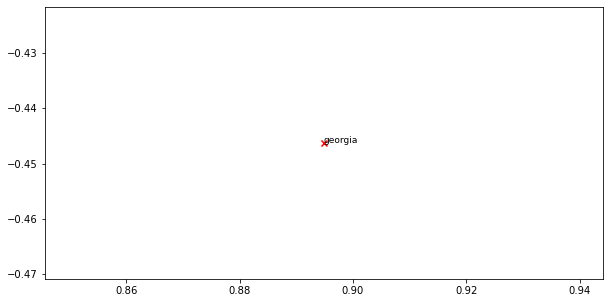

plot done


In [74]:

print("words array")
print(words)

plot_embeddings(M_normalized, word2Ind_co_occurrence, ["georgia"])
print("plot done")

In [75]:
word2Ind_co_occurrence

{'<START>': 1,
 'georgia': 3016,
 'down': 2159,
 'two': 7422,
 'russian': 6123,
 'warplane': 7733,
 'a': 2,
 'country': 1606,
 'move': 4603,
 'to': 7213,
 'brink': 907,
 'of': 4859,
 'war': 7719,
 '<END>': 0,
 'why': 7827,
 'wont': 7890,
 'america': 270,
 'and': 292,
 'nato': 4681,
 'help': 3303,
 'u': 7427,
 'if': 3480,
 'they': 7147,
 'now': 4803,
 'did': 1996,
 'we': 7758,
 'them': 7138,
 'in': 3539,
 'iraq': 3744,
 'remember': 5861,
 'that': 7131,
 'year': 7964,
 'old': 4883,
 'who': 7823,
 'at': 475,
 'the': 7134,
 'opening': 4907,
 'ceremony': 1148,
 'wa': 7700,
 'fake': 2645,
 'too': 7233,
 's': 6127,
 'refuse': 5813,
 'israel': 3768,
 'weapon': 7765,
 'attack': 487,
 'iran': 3742,
 'report': 5894,
 'all': 229,
 'expert': 2566,
 'admit': 112,
 'should': 6419,
 'legalise': 4057,
 'drug': 2209,
 'mom': 4534,
 'missing': 4500,
 'gay': 2987,
 'man': 4284,
 'bad': 565,
 'he': 3264,
 'not': 4791,
 'then': 7140,
 'd': 1728,
 'still': 6766,
 'be': 638,
 'looking': 4187,
 'for': 2840,
 '

In [66]:
corpus

[['<START>',
  'how',
  'do',
  'i',
  'test',
  'for',
  'an',
  'empty',
  'javascript',
  'object',
  '?',
  '',
  '<END>'],
 ['<START>',
  'how',
  'can',
  'i',
  'convert',
  'a',
  'string',
  'to',
  'boolean',
  'in',
  'javascript',
  '?',
  '',
  '<END>'],
 ['<START>',
  'open',
  'a',
  'url',
  'in',
  'a',
  'new',
  'tab',
  '(',
  'and',
  'not',
  'a',
  'new',
  'window',
  ')',
  '',
  '<END>'],
 ['<START>',
  'check',
  'if',
  'a',
  'variable',
  'is',
  'a',
  'string',
  'in',
  'javascript',
  '<END>'],
 ['<START>',
  'how',
  'to',
  'loop',
  'through',
  'a',
  'javascript',
  'object',
  'with',
  'the',
  'objects',
  'as',
  '?',
  '',
  '<END>'],
 ['<START>',
  'how',
  'do',
  'i',
  'check',
  'if',
  'an',
  'object',
  'has',
  'a',
  'specific',
  'property',
  'in',
  'javascript',
  '?',
  '',
  '<END>'],
 ['<START>',
  'how',
  'do',
  'i',
  'remove',
  'a',
  'key',
  'from',
  'a',
  'javascript',
  'object',
  '?',
  '',
  '<END>'],
 ['<START

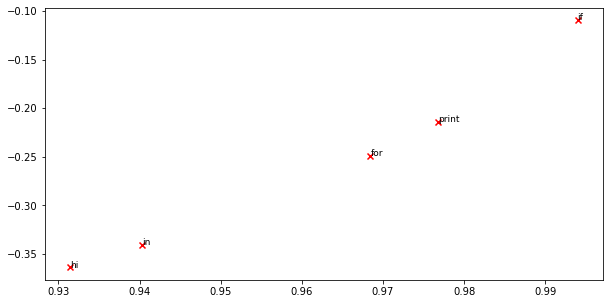

In [77]:
words = ['for', 'in', 'if', 'print', 'hi']
#ords = corpus [0]
plot_embeddings(M_normalized, word2Ind_co_occurrence, words)


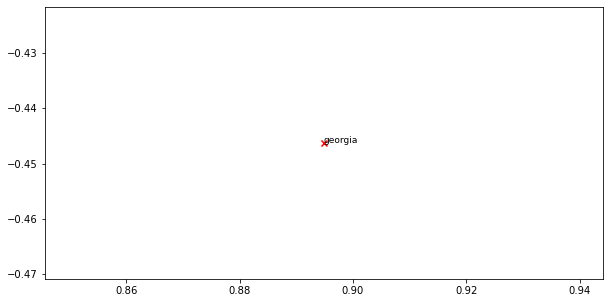

In [79]:
words = corpus [1]
plot_embeddings(M_normalized, word2Ind_co_occurrence, [words])

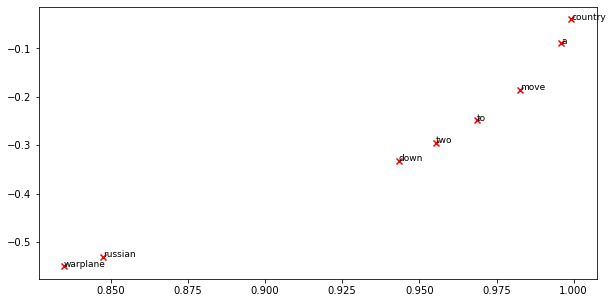

In [81]:
words = corpus [2:10]
plot_embeddings(M_normalized, word2Ind_co_occurrence, words)

In [82]:
embeddings = {
    'M_co_occurrence':M_co_occurrence,
    'word2Ind_co_occurrence':word2Ind_co_occurrence,
    'M_reduced_co_occurrence':M_reduced_co_occurrence,
    'M_lengths':M_lengths,
    'M_normalized':M_normalized
       }

print(embeddings)

{'M_co_occurrence': array([[0.000e+00, 0.000e+00, 4.588e+03, ..., 2.100e+01, 2.000e+00,
        5.000e+00],
       [0.000e+00, 0.000e+00, 4.441e+03, ..., 2.300e+01, 2.000e+00,
        5.000e+00],
       [4.588e+03, 4.441e+03, 3.422e+03, ..., 5.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [2.100e+01, 2.300e+01, 5.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.000e+00, 2.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [5.000e+00, 5.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00]]), 'word2Ind_co_occurrence': {'<START>': 1, 'georgia': 3016, 'down': 2159, 'two': 7422, 'russian': 6123, 'warplane': 7733, 'a': 2, 'country': 1606, 'move': 4603, 'to': 7213, 'brink': 907, 'of': 4859, 'war': 7719, '<END>': 0, 'why': 7827, 'wont': 7890, 'america': 270, 'and': 292, 'nato': 4681, 'help': 3303, 'u': 7427, 'if': 3480, 'they': 7147, 'now': 4803, 'did': 1996, 'we': 7758, 'them': 7138, 'in': 3539, 'iraq': 3744, 'remember': 5861, 

In [83]:
df_M_co_occurrence = pd.DataFrame(M_co_occurrence)
df_M_co_occurrence.to_csv("df_M_co_occurrence.csv")

In [84]:
import json
with open('json_word2Ind_co_occurrence.json', 'w') as outfile:
    json.dump(word2Ind_co_occurrence, outfile)



In [85]:
MCO = pd.read_csv("df_M_co_occurrence.csv", index_col = 0)

In [86]:
MCO=MCO.values

In [87]:
MCO

array([[0.000e+00, 0.000e+00, 4.588e+03, ..., 2.100e+01, 2.000e+00,
        5.000e+00],
       [0.000e+00, 0.000e+00, 4.441e+03, ..., 2.300e+01, 2.000e+00,
        5.000e+00],
       [4.588e+03, 4.441e+03, 3.422e+03, ..., 5.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [2.100e+01, 2.300e+01, 5.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.000e+00, 2.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [5.000e+00, 5.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

In [88]:
import json

with open('json_word2Ind_co_occurrence.json') as f:
      W2ICO = json.load(f)

# Output: {'name': 'Bob', 'languages': ['English', 'Fench']}
print(W2ICO)

{'<START>': 1, 'georgia': 3016, 'down': 2159, 'two': 7422, 'russian': 6123, 'warplane': 7733, 'a': 2, 'country': 1606, 'move': 4603, 'to': 7213, 'brink': 907, 'of': 4859, 'war': 7719, '<END>': 0, 'why': 7827, 'wont': 7890, 'america': 270, 'and': 292, 'nato': 4681, 'help': 3303, 'u': 7427, 'if': 3480, 'they': 7147, 'now': 4803, 'did': 1996, 'we': 7758, 'them': 7138, 'in': 3539, 'iraq': 3744, 'remember': 5861, 'that': 7131, 'year': 7964, 'old': 4883, 'who': 7823, 'at': 475, 'the': 7134, 'opening': 4907, 'ceremony': 1148, 'wa': 7700, 'fake': 2645, 'too': 7233, 's': 6127, 'refuse': 5813, 'israel': 3768, 'weapon': 7765, 'attack': 487, 'iran': 3742, 'report': 5894, 'all': 229, 'expert': 2566, 'admit': 112, 'should': 6419, 'legalise': 4057, 'drug': 2209, 'mom': 4534, 'missing': 4500, 'gay': 2987, 'man': 4284, 'bad': 565, 'he': 3264, 'not': 4791, 'then': 7140, 'd': 1728, 'still': 6766, 'be': 638, 'looking': 4187, 'for': 2840, 'him': 3342, 'an': 283, 'afghan': 149, 'prison': 5469, 'majority': 4

Running Truncated SVD over 8004 words...
Done.
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2) done
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting
words array


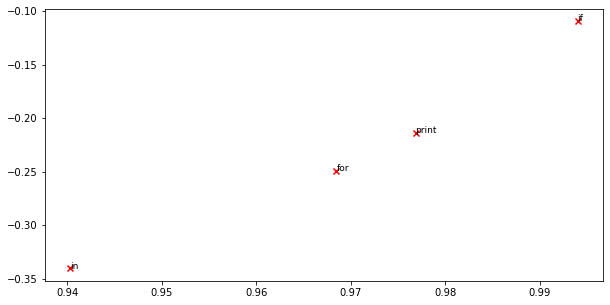

plot done


In [89]:
M_reduced_co_occurrence = reduce_to_k_dim(MCO, k=2)
print("M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2) done")

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
print("M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)")
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting
print("M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting")

words = ['for', 'in', 'if', 'print']
print("words array")

plot_embeddings(M_normalized, W2ICO, words)
print("plot done")

In [90]:
M_normalized

array([[ 0.85764674,  0.51423931],
       [ 0.85469637,  0.51912823],
       [ 0.99595401, -0.08986438],
       ...,
       [ 0.89793739, -0.44012321],
       [ 0.99998209,  0.00598413],
       [ 0.87655157, -0.48130795]])

In [94]:
my_embedding = {w: M_normalized[W2ICO[w]] for w in words}
my_embedding['georgia']

KeyError: 'georgia'

In [95]:
import torch
torch.cuda.is_available()

True

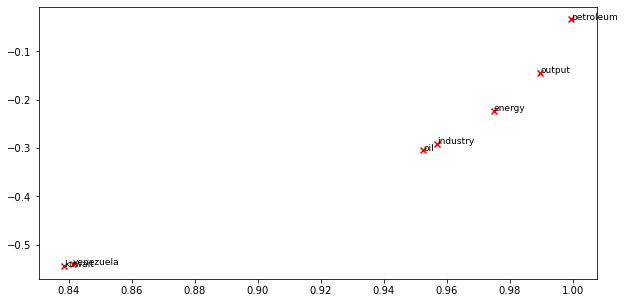

In [97]:
words = [ 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']
plot_embeddings(M_normalized, word2Ind_co_occurrence, words)

#### <font color="red">Write your answer here.</font>

What clusters together in 2-dimensional embedding space? 
Coutries: "kuwait", "venezuela", "ecuador"
energy related words: "oil", "energy", "petroleum", "industry"

What doesn't cluster together that you might think should have?
"bpd" and "barrels" should be clusted with "oil"

## Part 2: Prediction-Based Word Vectors (15 points)

As discussed in class, more recently prediction-based word vectors have demonstrated better performance, such as word2vec and GloVe (which also utilizes the benefit of counts). Here, we shall explore the embeddings produced by GloVe. Please revisit the class notes and lecture slides for more details on the word2vec and GloVe algorithms. If you're feeling adventurous, challenge yourself and try reading [GloVe's original paper](https://nlp.stanford.edu/pubs/glove.pdf).

Then run the following cells to load the GloVe vectors into memory. **Note**: If this is your first time to run these cells, i.e. download the embedding model, it will take about 15 minutes to run. If you've run these cells before, rerunning them will load the model without redownloading it, which will take about 1 to 2 minutes.

In [22]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(wv_from_bin.vocab.keys()))
    return wv_from_bin

In [23]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This will take several minutes
# -----------------------------------
wv_from_bin = load_embedding_model()

[==================================================] 100.0% 252.1/252.1MB downloaded
Loaded vocab size 400000


#### Note: If you are receiving reset by peer error, rerun the cell to restart the download. 

### Reducing dimensionality of Word Embeddings
Let's directly compare the GloVe embeddings to those of the co-occurrence matrix. In order to avoid running out of memory, we will work with a sample of 10000 GloVe vectors instead.
Run the following cells to:

1. Put 10000 Glove vectors into a matrix M
2. Run reduce_to_k_dim (your Truncated SVD function) to reduce the vectors from 200-dimensional to 2-dimensional.

In [24]:
def get_matrix_of_vectors(wv_from_bin, required_words=['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']):
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2Ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.vocab.keys())
    print("Shuffling words ...")
    random.seed(224)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2Ind and matrix M..." % len(words))
    word2Ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2Ind

In [25]:
# -----------------------------------------------------------------
# Run Cell to Reduce 200-Dimensional Word Embeddings to k Dimensions
# Note: This should be quick to run
# -----------------------------------------------------------------
M, word2Ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting

Shuffling words ...
Putting 10000 words into word2Ind and matrix M...
Done.
Running Truncated SVD over 10010 words...
Done.


**Note: If you are receiving out of memory issues on your local machine, try closing other applications to free more memory on your device. You may want to try restarting your machine so that you can free up extra memory. Then immediately run the jupyter notebook and see if you can load the word vectors properly. If you still have problems with loading the embeddings onto your local machine after this, please follow the Piazza instructions, as how to run remotely on Stanford Farmshare machines.**

### Question 2.1: GloVe Plot Analysis [written] (4 points)

Run the cell below to plot the 2D GloVe embeddings for `['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']`.

What clusters together in 2-dimensional embedding space? What doesn't cluster together that you might think should have? How is the plot different from the one generated earlier from the co-occurrence matrix? What is a possible reason for causing the difference?

['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']


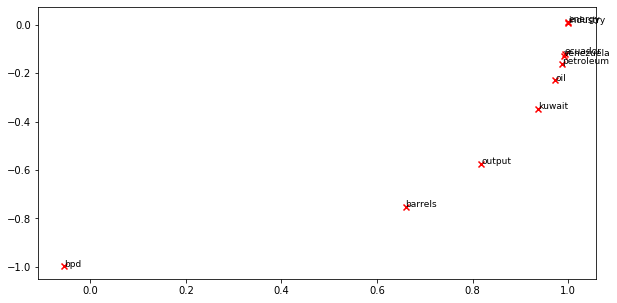

In [26]:
words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']
plot_embeddings(M_reduced_normalized, word2Ind, words)

#### <font color="red">Write your answer here.</font>

What clusters together in 2-dimensional embedding space? 
Words related to oil and petroleum: "venezuela", "petroleum", "oil", "kuwait"
South American countries: "venezuela", "ecuador"

What doesn't cluster together that you might think should have? 
"bpd" and "barrels" should be clusted with "oil"

How is the plot different from the one generated earlier from the co-occurrence matrix? 
"oil" had come closer to kuwait as well.

What is a possible reason for causing the difference?

### Cosine Similarity
Now that we have word vectors, we need a way to quantify the similarity between individual words, according to these vectors. One such metric is cosine-similarity. We will be using this to find words that are "close" and "far" from one another.

We can think of n-dimensional vectors as points in n-dimensional space. If we take this perspective [L1](http://mathworld.wolfram.com/L1-Norm.html) and [L2](http://mathworld.wolfram.com/L2-Norm.html) Distances help quantify the amount of space "we must travel" to get between these two points. Another approach is to examine the angle between two vectors. From trigonometry we know that:

<img src="./imgs/inner_product.png" width=20% style="float: center;"></img>

Instead of computing the actual angle, we can leave the similarity in terms of $similarity = cos(\Theta)$. Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 

### Question 2.2: Words with Multiple Meanings (2 points) [code + written] 
Polysemes and homonyms are words that have more than one meaning (see this [wiki page](https://en.wikipedia.org/wiki/Polysemy) to learn more about the difference between polysemes and homonyms ). Find a word with at least 2 different meanings such that the top-10 most similar words (according to cosine similarity) contain related words from *both* meanings. For example, "leaves" has both "vanishes" and "stalks" in the top 10, and "scoop" has both "handed_waffle_cone" and "lowdown". You will probably need to try several polysemous or homonymic words before you find one. Please state the word you discover and the multiple meanings that occur in the top 10. Why do you think many of the polysemous or homonymic words you tried didn't work (i.e. the top-10 most similar words only contain **one** of the meanings of the words)?

**Note**: You should use the `wv_from_bin.most_similar(word)` function to get the top 10 similar words. This function ranks all other words in the vocabulary with respect to their cosine similarity to the given word. For further assistance please check the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.

In [42]:
# ------------------
# Write your implementation here.
print("mouse")
print(wv_from_bin.most_similar("mouse"))
print("bank")
print(wv_from_bin.most_similar("bank"))
print("bat")
print(wv_from_bin.most_similar("bat"))


# ------------------

mouse
[('mice', 0.6580958366394043), ('keyboard', 0.5548278093338013), ('rat', 0.5433950424194336), ('rabbit', 0.5192376971244812), ('cat', 0.5077415704727173), ('cursor', 0.5058691501617432), ('trackball', 0.5048902630805969), ('joystick', 0.49841049313545227), ('mickey', 0.47242847084999084), ('clicks', 0.4722805917263031)]
bank
[('banks', 0.7625691890716553), ('banking', 0.6818838119506836), ('central', 0.6283639073371887), ('financial', 0.6166563034057617), ('credit', 0.6049751043319702), ('lending', 0.5980608463287354), ('monetary', 0.5963003039360046), ('bankers', 0.5913101434707642), ('loans', 0.5802939534187317), ('investment', 0.5740202069282532)]
bat
[('bats', 0.691724419593811), ('batting', 0.6160587668418884), ('balls', 0.5692733526229858), ('batted', 0.5530908107757568), ('toss', 0.5506129264831543), ('wicket', 0.5495278835296631), ('pitch', 0.548936128616333), ('bowled', 0.5452010631561279), ('hitter', 0.5353438854217529), ('batsman', 0.5348091125488281)]


#### <font color="red">Write your answer here.</font>
"mouse": "rat", "trackball" or "cursor"

https://frnsys.com/ai_notes/machine_learning/natural_language_processing.html

### Question 2.3: Synonyms & Antonyms (2 points) [code + written] 

When considering Cosine Similarity, it's often more convenient to think of Cosine Distance, which is simply 1 - Cosine Similarity.

Find three words (w1,w2,w3) where w1 and w2 are synonyms and w1 and w3 are antonyms (opposite), but Cosine Distance(w1,w3) < Cosine Distance(w1,w2). For example, w1="happy" is closer to w3="sad" than to w2="cheerful". 

Once you have found your example, please give a possible explanation for why this counter-intuitive result may have happened.

You should use the the `wv_from_bin.distance(w1, w2)` function here in order to compute the cosine distance between two words. Please see the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.distance)__ for further assistance.

In [45]:
# ------------------
# Write your implementation here.
#w1 = "happy"
#w2 = "cheers"
#w3 = "sad"

w1 = "respect"
w2 = "admire"
w3 = "disrespect"

distance_w1_w2 = wv_from_bin.distance(w1, w2)
distance_w1_w3 = wv_from_bin.distance(w1, w3)

print(distance_w1_w2)
print(distance_w1_w3)

# ------------------

0.5734543800354004
0.5215198993682861


#### <font color="red">Write your answer here.</font> [NOT THE CORRECT ANSWER]
theta is the agle between two words.
If theta = 0, that means words are on same dorection. => Similar words, cost(theta)=1 if both words are exactly similar.
When theta increases, the dissimilarity increases. Maximum dissimilarity occurs when theta = 180 degrees. At this occation cos(theta) = cos(180) = -1

This implies that similarity ranges from 1 to -1; 1 implies most similarity and -1 implies most dissimilarity. so highest cos values imply most similar words, lower cos values imples 

### Solving Analogies with Word Vectors
Word vectors have been shown to *sometimes* exhibit the ability to solve analogies. 

As an example, for the analogy "man : king :: woman : x" (read: man is to king as woman is to x), what is x?

In the cell below, we show you how to use word vectors to find x. The `most_similar` function finds words that are most similar to the words in the `positive` list and most dissimilar from the words in the `negative` list. The answer to the analogy will be the word ranked most similar (largest numerical value).

**Note:** Further Documentation on the `most_similar` function can be found within the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.

In [46]:
# Run this cell to answer the analogy -- man : king :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'king'], negative=['man']))

[('queen', 0.6978678703308105),
 ('princess', 0.6081745028495789),
 ('monarch', 0.5889754891395569),
 ('throne', 0.5775108933448792),
 ('prince', 0.5750998258590698),
 ('elizabeth', 0.5463595986366272),
 ('daughter', 0.5399125814437866),
 ('kingdom', 0.5318052172660828),
 ('mother', 0.5168544054031372),
 ('crown', 0.5164473056793213)]


### Question 2.4: Finding Analogies [code + written]  (2 Points)
Find an example of analogy that holds according to these vectors (i.e. the intended word is ranked top). In your solution please state the full analogy in the form x:y :: a:b. If you believe the analogy is complicated, explain why the analogy holds in one or two sentences.

**Note**: You may have to try many analogies to find one that works!

In [100]:
# ------------------
# Write your implementation here.
pprint.pprint(wv_from_bin.most_similar(positive=['girl', 'father'], negative=['boy']))

# ------------------

[('mother', 0.8463385105133057),
 ('daughter', 0.830620288848877),
 ('wife', 0.799027681350708),
 ('husband', 0.7946300506591797),
 ('son', 0.7387049198150635),
 ('sister', 0.7211031913757324),
 ('married', 0.7200812101364136),
 ('daughters', 0.7176699638366699),
 ('her', 0.7135908603668213),
 ('grandmother', 0.6897495985031128)]


#### <font color="red">Write your answer here.</font>

### Question 2.5: Incorrect Analogy [code + written] (1 point)
Find an example of analogy that does *not* hold according to these vectors. In your solution, state the intended analogy in the form x:y :: a:b, and state the (incorrect) value of b according to the word vectors.

In [101]:
# ------------------
# Write your implementation here.
pprint.pprint(wv_from_bin.most_similar(positive=['girl', 'brother'], negative=['boy']))

# ------------------

[('daughter', 0.805823802947998),
 ('cousin', 0.7796304821968079),
 ('son', 0.7571232914924622),
 ('wife', 0.7448715567588806),
 ('sister', 0.7441308498382568),
 ('father', 0.7369656562805176),
 ('niece', 0.7302137613296509),
 ('nephew', 0.730190634727478),
 ('husband', 0.7162861227989197),
 ('mother', 0.7117223739624023)]


#### <font color="red">Write your answer here.</font>

### Question 2.6: Guided Analysis of Bias in Word Vectors [written] (1 point)

It's important to be cognizant of the biases (gender, race, sexual orientation etc.) implicit in our word embeddings. Bias can be dangerous because it can reinforce stereotypes through applications that employ these models.

Run the cell below, to examine (a) which terms are most similar to "woman" and "worker" and most dissimilar to "man", and (b) which terms are most similar to "man" and "worker" and most dissimilar to "woman". Point out the difference between the list of female-associated words and the list of male-associated words, and explain how it is reflecting gender bias.

In [96]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'worker'], negative=['man']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'worker'], negative=['woman']))

[('employee', 0.6375863552093506),
 ('workers', 0.6068919897079468),
 ('nurse', 0.5837947130203247),
 ('pregnant', 0.5363885760307312),
 ('mother', 0.5321309566497803),
 ('employer', 0.5127025842666626),
 ('teacher', 0.5099577307701111),
 ('child', 0.5096741914749146),
 ('homemaker', 0.5019455552101135),
 ('nurses', 0.4970571994781494)]

[('workers', 0.611325740814209),
 ('employee', 0.5983108878135681),
 ('working', 0.5615329742431641),
 ('laborer', 0.5442320108413696),
 ('unemployed', 0.5368517637252808),
 ('job', 0.5278826951980591),
 ('work', 0.5223963260650635),
 ('mechanic', 0.5088937282562256),
 ('worked', 0.5054520964622498),
 ('factory', 0.4940453767776489)]


#### <font color="red">Write your answer here.</font>
In the woman-associated list, words such as "pregnant", "mother", "homemaker", "child", "nurses" represetns the typical human related behavior.
In the man-associated list, words such as "laborer", "mechanic", "factory" shows the typical man-strength related jobs.

### Question 2.7: Independent Analysis of Bias in Word Vectors [code + written]  (1 point)

Use the `most_similar` function to find another case where some bias is exhibited by the vectors. Please briefly explain the example of bias that you discover.

In [108]:
# ------------------
# Write your implementation here.
pprint.pprint(wv_from_bin.most_similar(positive=['mother', 'money'], negative=['father']))

pprint.pprint(wv_from_bin.most_similar(positive=['father', 'money'], negative=['mother']))


# ------------------

[('cash', 0.6875389218330383),
 ('funds', 0.6787812113761902),
 ('fund', 0.6027991771697998),
 ('donations', 0.5954762697219849),
 ('amount', 0.5937567949295044),
 ('get', 0.579010009765625),
 ('aid', 0.5737360715866089),
 ('spend', 0.5705865025520325),
 ('taxpayer', 0.5655536651611328),
 ('funding', 0.561586856842041)]
[('funds', 0.6888772249221802),
 ('cash', 0.6408715844154358),
 ('paid', 0.6122925281524658),
 ('paying', 0.603430449962616),
 ('billions', 0.5974615812301636),
 ('pay', 0.5901223421096802),
 ('millions', 0.5747710466384888),
 ('invested', 0.5728987455368042),
 ('fund', 0.5694814920425415),
 ('financing', 0.5590224266052246)]


#### <font color="red">Write your answer here.</font>

### Question 2.8: Thinking About Bias [written] (2 points)

What might be the causes of these biases in the word vectors? You should give least 2 explainations how bias get into the word vectors. How might you be able to investigate/test these causes?

1. training on an biased corpus
2. intrinsic bias in true systems such as gender bias which is very difficult to eliminate


#### <font color="red">Write your answer here.</font>

# <font color="blue"> Submission Instructions</font>

1. Click the Save button at the top of the Jupyter Notebook.
2. Select Cell -> All Output -> Clear. This will clear all the outputs from all cells (but will keep the content of all cells). 
2. Select Cell -> Run All. This will run all the cells in order, and will take several minutes.
3. Once you've rerun everything, select File -> Download as -> PDF via LaTeX (If you have trouble using "PDF via LaTex", you can also save the webpage as pdf. <font color='blue'> Make sure all your solutions especially the coding parts are displayed in the pdf</font>, it's okay if the provided codes get cut off because lines are not wrapped in code cells).
4. Look at the PDF file and make sure all your solutions are there, displayed correctly. The PDF is the only thing your graders will see!
5. Submit your PDF on Gradescope.